### Static Bayesian Optimization: 
- initial training on burnin points
- use acquisition function to guide next sampling
- re-optimize the model
- plot and visualize before and after
- loop and use acquistion function for up to 100 samples. 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [48]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, ker_BaO, slice_dim, ylabel, initialize_data_dr_sim):
        
        sampling_freq = np.empty((n_samples))
        sampling_freq[:] = 35
        sampling_amp = np.empty((n_samples))
        sampling_amp[:] = 40

        testX_BaO = np.array([sampling_freq, sampling_amp])
        testX = np.transpose(testX_BaO)
        
        state_est_BaO = np.empty((n_samples,1))
        simY_BaO = np.empty((n_samples, 1))
        simMse_BaO = np.empty((n_samples, 1))

        for i in range(n_samples-1):
            state_est_BaO[i:i+2, 0], simY_BaO[i:i+2,0:1], simMse_BaO[i:i+2,0:1] = self.sample(testX_BaO, trained_model_BaO);

        print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
        
        nu = 0.1
        print("nu set at: ", nu)
        ucb = np.empty((1))
        freq_choices = [5,7,11,17, 23, 35, 42]

        ucb= self.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
        median_ucb = np.median(ucb)
        next_freq_idx = abs(median_ucb-freq_choices).argmin()
          
        for idx in range(n_samples, np.shape(U1)[0]):
            if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
                # print(idx)
                next_idx_to_optimize.append(idx)
                if np.size(next_idx_to_optimize)>n_samples:
                    break
        
        U1_next = U1.loc[next_idx_to_optimize,:]
        X0_psd_next = X0_psd.loc[next_idx_to_optimize]
        X1_next = X1[next_idx_to_optimize,:]
        
        U1_combo = pd.concat([U1_init,U1_next])
        X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
        X1_combo = np.append(X1_init, X1_next, axis=0)
        
        U1_combo.reset_index()
        U1_combo=U1_combo[['Stim_1', 'Stim_2']]

        X0_psd_combo.reset_index()
        X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
        
        x_BaO, y_BaO, trained_model_BaO = self.initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)
        
        return x_BaO, y_BaO, trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [36]:
model = state_dr_gp()

In [37]:
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [38]:
print('Sum preStim gamma are: \n', X0_psd, '\n','freq and amplitude used are: \n', U1[0:4])

Sum preStim gamma are: 
      sum_preStim_gamma
0             3.266571
1             2.425945
2             3.117866
3             2.868627
4             3.521665
..                 ...
379           1.268502
380           1.239859
381           1.880050
382           1.199899
383           1.343332

[384 rows x 1 columns] 
 freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [39]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

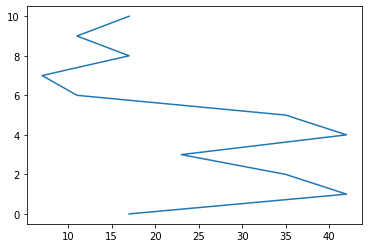

In [40]:
plt.plot(U1.loc[0:10,'Stim_1'], np.arange(0,11));

In [41]:
print(np.shape(U1), np.shape(X0_psd))

(384, 2) (384, 1)


In [42]:
n_burn_in = 20
n_samples= 10


In [43]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = X0_psd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init)
print('sum postStim gamma are: \n', X1_init)

Sum preStim gamma are: 
     sum_preStim_gamma
0            3.266571
1            2.425945
2            3.117866
3            2.868627
4            3.521665
5            1.384478
6            1.420178
7            1.533292
8            2.019014
9            2.231953
10           2.347957
11           2.131811
12           1.934441
13           2.512154
14           4.690816
15           2.645199
16           6.401632
17           1.984354
18           3.580944
19           2.032816 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16.68010

In [44]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

#### initial training

In [45]:
ker_BaO = GPy.kern.Matern52(input_dim=2, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [46]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x201e570a580>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x201e55d4970>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   6.650130e+02   1.070147e+04 
    00s11  0006   2.717979e+02   2.868045e+02 
    00s15  0008   1.702266e+02   4.102541e+01 
    00s19  0011   8.975792e+01   2.859550e-01 
    00s55  0053   6.946105e+01   2.090506e-10 
Runtime:     00s55
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x201e89bcbb0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x201e89bcee0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x201e8af2e20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x201e8b00280>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x201e8b002b0>]}

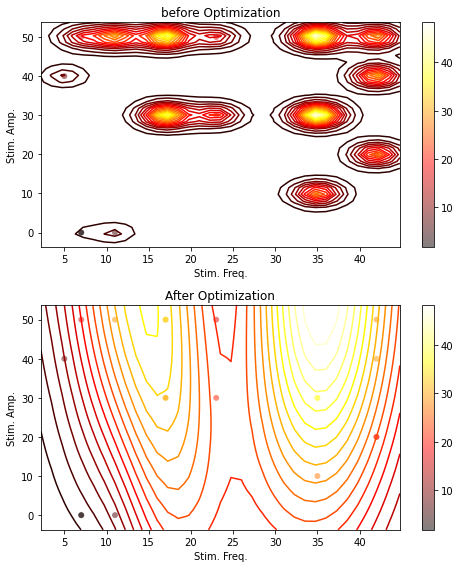

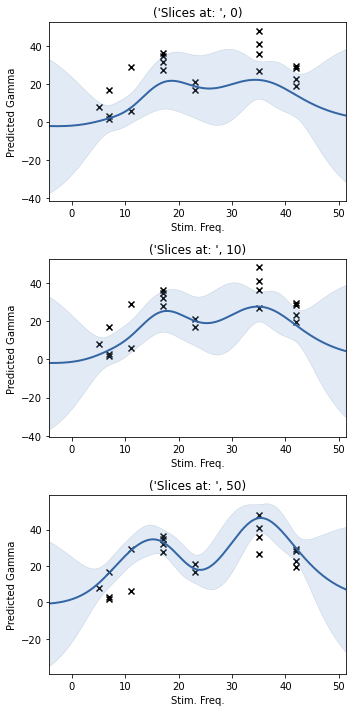

In [47]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO, slice_dim, ylabel)

#### use the acquisition function to guide the next freq to optimize at

sampling_freq = np.empty((n_samples))
sampling_freq[:] = 35
sampling_amp = np.empty((n_samples))
sampling_amp[:] = 40
print(np.shape(sampling_freq), np.shape(sampling_amp))

testX_BaO = np.array([sampling_freq, sampling_amp])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(testX_BaO[0:2, 0:1])

state_est_BaO = np.empty((n_samples,1))
simY_BaO = np.empty((n_samples, 1))
simMse_BaO = np.empty((n_samples, 1))

for i in range(n_samples-1):
        # print(i)
    state_est_BaO[i:i+2, 0], simY_BaO[i:i+2,0:1], simMse_BaO[i:i+2,0:1] = model.sample(testX_BaO, trained_model_BaO);

print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])
# posteriorTestY
print(np.shape(state_est_BaO),'\n',state_est_BaO[0:10, 0:2])
print(np.shape(simY_BaO),'\n', np.shape(simMse_BaO))

# inspecting the inputs to acquistion_function:
print(np.shape(testX_BaO))
print(testX_BaO[:,0:3])

# Mean and variance after initial training using "burn-in" points:
print("mean is: \n",simY_BaO[0, 0],"\n\n Variance is: \n", simMse_BaO[0, 0])

nu = 0.1
print("nu set at: ", nu)
# t = the sample we are on 

ucb = np.empty((1))
freq_choices = [5,7,11,17, 23, 35, 42]

ucb= model.acquisition_function(simY_BaO, simMse_BaO, nu, 1)
# print(np.shape(ucb))
median_ucb = np.median(ucb)
next_freq_idx = abs(median_ucb-freq_choices).argmin()
    
print(median_ucb)
print(next_freq_idx, 'next freq is: ', freq_choices[6])

np.shape(U1)[0]
print(U1.loc[20,'Stim_1'])

# From sample #20next_idx_to_optimize, pick 20 samples in U1, X0 and X1 such that the freq = 42
next_idx_to_optimize = []

for idx in range(n_samples, np.shape(U1)[0]):
    if U1.loc[idx,'Stim_1']==freq_choices[next_freq_idx]:
        # print(idx)
        next_idx_to_optimize.append(idx)
        if np.size(next_idx_to_optimize)>n_samples:
            break
        
print(next_idx_to_optimize)

U1_next = U1.loc[next_idx_to_optimize,:]
X0_psd_next = X0_psd.loc[next_idx_to_optimize]
X1_next = X1[next_idx_to_optimize,:]
print('Sum preStim gamma are: \n', X0_psd_next, '\n','freq and amplitude used are: \n', U1_next)
print('sum postStim gamma are: \n', X1_next, '\n', np.shape(X1_next))

#### Plot before and after optimization 

# Combine initial samples with next samples
U1_combo = pd.concat([U1_init,U1_next])
X0_psd_combo = pd.concat([X0_psd_init, X0_psd_next])
X1_combo = np.append(X1_init, X1_next, axis=0)

print(np.shape(X1_combo))
print(U1_combo, '\n', X0_psd_combo.head(), '\n', X1_combo[0:4])

U1_combo.reset_index()
U1_combo=U1_combo[['Stim_1', 'Stim_2']]
U1_combo.head()

X0_psd_combo.reset_index()
X0_psd_combo= X0_psd_combo[['sum_preStim_gamma']]
X0_psd_combo.head()


mean is: 
 41.03700797059547 

 Variance is: 
 12.19036043080962
nu set at:  0.1


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x201e8be2b20>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x201e8bb3ac0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0003   1.049527e+02   2.273377e-01 
    00s19  0006   1.045075e+02   8.167776e-04 
    00s61  0031   1.042294e+02   1.537656e-12 
Runtime:     00s61
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x201e9de0dc0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x201e9dcb9a0>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x201e9f26190>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x201e9f266d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x201e9f26700>]}

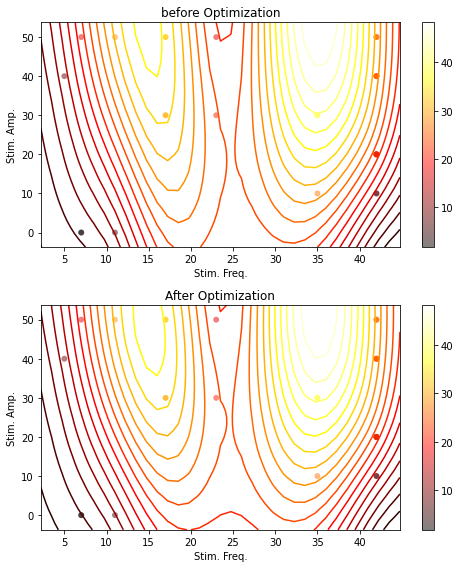

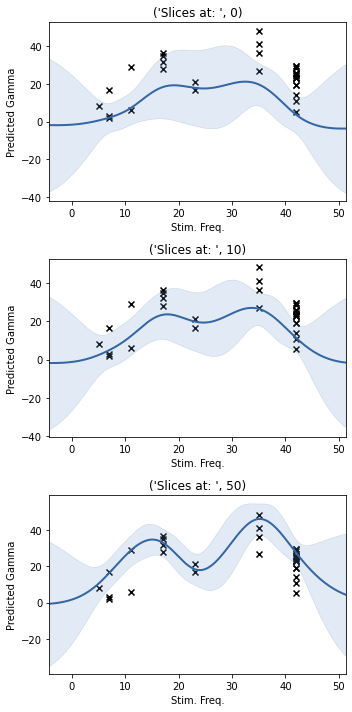

In [49]:
x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, ker_BaO, slice_dim, ylabel)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end

##### the actual acquisition function is: upper_confidence_bound()

function ucb = upper_confidence_bound(Y_mean, Y_uncertainty, nu, t)

beta   	= 2 * log(t.^2*pi^2/(6));
ucb     = Y_mean + sqrt(nu*beta) * Y_uncertainty;

end

In [52]:
nu = 0.1
# t = the sample we are on 
